Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    name = f.namelist()[0]
    data = tf.compat.as_str(f.read(name))
  return data
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [5]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [6]:
batch_size=64
num_unrollings=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f certain d', 'at it will ', 'e convince ', 'ent told hi', 'ampaign and', 'rver side s', 'ious texts ', 'o capitaliz', 'a duplicate', 'gh ann es d', 'ine january', 'ross zero t', 'cal theorie', 'ast instanc', ' dimensiona', 'most holy m', 't s support', 'u is still ', 'e oscillati', 'o eight sub', 'of italy la', 's the tower', 'klahoma pre', 'erprise lin', 'ws becomes ', 'et in a naz', 'the fabian ', 'etchy to re', ' sharman ne', 'ised empero', 'ting in pol', 'd neo latin', 'th risky ri', 'encyclopedi', 'fense the a', 'duating fro', 'treet grid ', 'ations more', 'appeal of d', 'si have mad']
['ists advoca', 'ary governm', 'hes nat

In [7]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

Simple LSTM Model.

In [8]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [9]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.289788 learning rate: 10.000000
Minibatch perplexity: 26.84
blo iai ueug c atnwzqxpaubuilr elwrssrfbsimlyowf gudteyztkoismghxlpnh yfotu beju
jrnz mhh vlc dqvamsmahccs tosw  eh   csnqfareoocsoxu kmeclyzhb diopqp uvpro i by
qgslttj a  qdun tf udic fmqteunewivlwvh edc fweeuplnru  ae  caasn pgeyup s  uuhi
qvukb zbvmgms iqiclqkedtptgcdenoaeeerkj  qmixzdaycyiwtygzt rp  vtlwmea miqev dxi
pnykeqhkiqinaozgeydeacemte ihpd wz tawxtfqg rolerzi zhby hi ouzovq z kaojwljyehb
Validation set perplexity: 20.17
Average loss at step 100: 2.591148 learning rate: 10.000000
Minibatch perplexity: 10.78
Validation set perplexity: 10.22
Average loss at step 200: 2.241021 learning rate: 10.000000
Minibatch perplexity: 8.56
Validation set perplexity: 8.55
Average loss at step 300: 2.090677 learning rate: 10.000000
Minibatch perplexity: 7.39
Validation set perplexity: 8.05
Average loss at step 400: 1.993820 learning rate: 10.000000
Minibatch perplexity: 7.34
Validation set per

Validation set perplexity: 4.42
Average loss at step 4500: 1.615942 learning rate: 10.000000
Minibatch perplexity: 5.34
Validation set perplexity: 4.65
Average loss at step 4600: 1.615650 learning rate: 10.000000
Minibatch perplexity: 4.99
Validation set perplexity: 4.56
Average loss at step 4700: 1.621887 learning rate: 10.000000
Minibatch perplexity: 5.19
Validation set perplexity: 4.46
Average loss at step 4800: 1.630415 learning rate: 10.000000
Minibatch perplexity: 4.46
Validation set perplexity: 4.47
Average loss at step 4900: 1.634638 learning rate: 10.000000
Minibatch perplexity: 5.06
Validation set perplexity: 4.55
Average loss at step 5000: 1.607506 learning rate: 1.000000
Minibatch perplexity: 4.43
as english a ran pitria havine danjringation him is hame often jesuper r fism wh
seb telf at septs hun make seven operal roch encoul but as liamosic pabil from t
ti has a b hu persic or polled in bases coverrea for invussing the that quacher 
goyan years list one nine eight sizuet

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [10]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Global: ix, fx, cx, ox concat, and im, fm, cm, om concat
  big_x = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes*4], -0.1, 0.1))
  big_m = tf.Variable(tf.truncated_normal([num_nodes, num_nodes*4], -0.1, 0.1))
  
  # Input gate: input, previous output, and bias.
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ob = tf.Variable(tf.zeros([1, num_nodes]))    
    
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    x = tf.matmul(i, big_x)
    m = tf.matmul(o, big_m)
    input_gate = tf.sigmoid(x[:,:num_nodes] + m[:,:num_nodes] + ib)
    forget_gate = tf.sigmoid(x[:,num_nodes:(num_nodes*2)] + m[:,num_nodes:(num_nodes*2)] + fb)
    update = x[:,num_nodes*2:(num_nodes*3)] + m[:,num_nodes*2:(num_nodes*3)] + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(x[:,num_nodes*3:(num_nodes*4)] + m[:,num_nodes*3:(num_nodes*4)] + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [11]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.294716 learning rate: 10.000000
Minibatch perplexity: 26.97
x xnv mifmetko  nmbpdxofr skki pitd aqtr glaieqtbbolzfkbvzvg xkchm egogf bdruema
yowxeme b cbe oa vl beejj ew ktltetix icvpk yqigryjhfwylhelbj ekapiapahueefwew x
twyrc eiptwhunorgdmy ah knihm kbx  joegl pa i d rb ws yjvuivchjri nsgi bfgwno p 
orjirfmyroybsamea  ppgto  ovdk aue lhvf pgskcsnngabishdnptusn  ag  ia oei hkcxtu
 catboxtk konlxwct sgaxzprsoymjkibudq iila bcanhev strk jxtzrueym ewic iafgb o h
Validation set perplexity: 20.08
Average loss at step 100: 2.591985 learning rate: 10.000000
Minibatch perplexity: 10.62
Validation set perplexity: 10.44
Average loss at step 200: 2.249274 learning rate: 10.000000
Minibatch perplexity: 8.33
Validation set perplexity: 8.79
Average loss at step 300: 2.088779 learning rate: 10.000000
Minibatch perplexity: 6.44
Validation set perplexity: 8.12
Average loss at step 400: 2.031816 learning rate: 10.000000
Minibatch perplexity: 7.67
Validation set per

Validation set perplexity: 4.79
Average loss at step 4500: 1.637461 learning rate: 10.000000
Minibatch perplexity: 5.09
Validation set perplexity: 4.93
Average loss at step 4600: 1.621365 learning rate: 10.000000
Minibatch perplexity: 5.29
Validation set perplexity: 4.76
Average loss at step 4700: 1.620678 learning rate: 10.000000
Minibatch perplexity: 4.80
Validation set perplexity: 4.74
Average loss at step 4800: 1.606029 learning rate: 10.000000
Minibatch perplexity: 4.79
Validation set perplexity: 4.82
Average loss at step 4900: 1.616398 learning rate: 10.000000
Minibatch perplexity: 5.14
Validation set perplexity: 4.69
Average loss at step 5000: 1.609704 learning rate: 1.000000
Minibatch perplexity: 4.90
ing contersaing tip continumented the nour one line the connitice in grails were
hing of d n infinestical break grions a have chapry frame among eight to the cul
rivary desopibality slactional ireprifals of the replaced are complements manuut
x naming the initance of the four seve

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

In [12]:
# Part A

embedding_size = 128 # Dimension of the embedding vector.
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  vocabulary_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

  # Global: ix, fx, cx, ox concat, and im, fm, cm, om concat
  big_x = tf.Variable(tf.truncated_normal([embedding_size, num_nodes*4], -0.1, 0.1))
  big_m = tf.Variable(tf.truncated_normal([num_nodes, num_nodes*4], -0.1, 0.1))
  
  # Input gate: input, previous output, and bias.
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ob = tf.Variable(tf.zeros([1, num_nodes]))    
    
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    x = tf.matmul(i, big_x)
    m = tf.matmul(o, big_m)
    input_gate = tf.sigmoid(x[:,:num_nodes] + m[:,:num_nodes] + ib)
    forget_gate = tf.sigmoid(x[:,num_nodes:(num_nodes*2)] + m[:,num_nodes:(num_nodes*2)] + fb)
    update = x[:,num_nodes*2:(num_nodes*3)] + m[:,num_nodes*2:(num_nodes*3)] + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(x[:,num_nodes*3:(num_nodes*4)] + m[:,num_nodes*3:(num_nodes*4)] + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.
    
  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    i_embed = tf.nn.embedding_lookup(vocabulary_embeddings, tf.argmax(i, axis=1))
    output, state = lstm_cell(i_embed, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  

  sample_input = tf.placeholder(tf.float32, shape=[1,vocabulary_size])
  sample_input_i = tf.argmax(sample_input, axis=1)
  sample_input_embedding = tf.nn.embedding_lookup(vocabulary_embeddings, sample_input_i)
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input_embedding, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))


In [13]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 3.311256 learning rate: 10.000000
Minibatch perplexity: 27.42
x bkt wli fj  gwieleoz ti zling dej h d uakea a n jee  s ycoahwkx a bomblyahs lo
ke e q  t mkr t  mev ot aalv eg md iy vht vmnloyi ekyc q ilt cni u  s v xer z xl
kid ey emzq  t lixmwj d ed r ps ewe s int  mffr r d ytsebr mfopfawztnt zoeyh hwz
wd yr   ap m xhpciqtveni ht r bwrhcreq n l noos  im eyooq crr s uy i kt nua asma
wr j des tiuq ls cgant ua hq glfhuli   rawt kymlrt n oawlh e t moq ahegkyat lue 
Validation set perplexity: 20.36
Average loss at step 100: 2.298770 learning rate: 10.000000
Minibatch perplexity: 9.99
Validation set perplexity: 9.07
Average loss at step 200: 2.021122 learning rate: 10.000000
Minibatch perplexity: 7.07
Validation set perplexity: 7.50
Average loss at step 300: 1.918565 learning rate: 10.000000
Minibatch perplexity: 6.09
Validation set perplexity: 6.83
Average loss at step 400: 1.863202 learning rate: 10.000000
Minibatch perplexity: 6.06
Validation set perpl

Validation set perplexity: 5.19
Average loss at step 4500: 1.640240 learning rate: 10.000000
Minibatch perplexity: 5.28
Validation set perplexity: 5.13
Average loss at step 4600: 1.638922 learning rate: 10.000000
Minibatch perplexity: 5.09
Validation set perplexity: 4.97
Average loss at step 4700: 1.613654 learning rate: 10.000000
Minibatch perplexity: 5.41
Validation set perplexity: 5.12
Average loss at step 4800: 1.596091 learning rate: 10.000000
Minibatch perplexity: 5.23
Validation set perplexity: 5.17
Average loss at step 4900: 1.611863 learning rate: 10.000000
Minibatch perplexity: 5.11
Validation set perplexity: 5.04
Average loss at step 5000: 1.639167 learning rate: 1.000000
Minibatch perplexity: 5.60
y the cussend or the colories dunomery ammonia bilege it trich still in the irel
pitim cashoulys accoined by gia the contable minuchbance in equing etheria on fo
ge since for guacemic being the cmistical cunctions formates to ansoma presents 
round hen bules is acciss cakekno brac

In [25]:
# Part B

embedding_size = 128 # Dimension of the embedding vector.
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  vocabulary_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size*vocabulary_size, embedding_size], -1.0, 1.0))

  # Global: ix, fx, cx, ox concat, and im, fm, cm, om concat
  big_x = tf.Variable(tf.truncated_normal([embedding_size, num_nodes*4], -0.1, 0.1))
  big_m = tf.Variable(tf.truncated_normal([num_nodes, num_nodes*4], -0.1, 0.1))
  
  # Input gate: input, previous output, and bias.
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ob = tf.Variable(tf.zeros([1, num_nodes]))    
    
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    x = tf.matmul(i, big_x)
    m = tf.matmul(o, big_m)
    input_gate = tf.sigmoid(x[:,:num_nodes] + m[:,:num_nodes] + ib)
    forget_gate = tf.sigmoid(x[:,num_nodes:(num_nodes*2)] + m[:,num_nodes:(num_nodes*2)] + fb)
    update = x[:,num_nodes*2:(num_nodes*3)] + m[:,num_nodes*2:(num_nodes*3)] + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(x[:,num_nodes*3:(num_nodes*4)] + m[:,num_nodes*3:(num_nodes*4)] + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_chars = train_data[:num_unrollings]
  train_inputs = zip(train_chars[:-1], train_chars[1:])
  train_labels = train_data[2:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    bigram_index = tf.argmax(i[0], axis=1) * vocabulary_size + tf.argmax(i[1], axis=1)
    i_embed = tf.nn.embedding_lookup(vocabulary_embeddings, bigram_index)
    output, state = lstm_cell(i_embed, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  sample_input = list()
  for _ in range(2):
    sample_input.append(tf.placeholder(tf.float32))
  samp_in_index = tf.argmax(sample_input[0], axis=1) * vocabulary_size + tf.argmax(sample_input[1], axis=1)
  sample_input_embedding = tf.nn.embedding_lookup(vocabulary_embeddings, samp_in_index)
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input_embedding, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))


  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(vocabulary_embeddings), 1, keep_dims=True))
  normalized_embeddings = vocabulary_embeddings / norm

In [26]:
import collections
num_steps = 7001
summary_frequency = 100

valid_batches = BatchGenerator(valid_text, 1, 2)

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[2:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          #feed = sample(random_distribution())
          feed = collections.deque(maxlen=2)
          for _ in range(2):  
            feed.append(random_distribution())
          #sentence = characters(feed)[0]
          sentence = characters(feed[0])[0] + characters(feed[1])[0]
          #print(sentence)
          #print(feed)
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({
                    sample_input[0]: feed[0],
                    sample_input[1]: feed[1]
                })
            #feed = sample(prediction)
            feed.append(sample(prediction))
            #sentence += characters(feed)[0]
            sentence += characters(feed[1])[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({
                    sample_input[0]: b[0],
                    sample_input[1]: b[1]
            })
        valid_logprob = valid_logprob + logprob(predictions, b[2])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))
  final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 3.279634 learning rate: 10.000000
Minibatch perplexity: 26.57
mhnci ieheewm   tmncv aa z sea dbo xsrgbek hikhkaiea j jnjletmfnuwmchqk j awver p
ao srsp casi ncbtoedxrwwlfij z zyf z  eiemfntk h d emeetpovani xseeixbav lhansa  
thjbu i hmiseka iymonqhtpobeysdjropejaobfe aetisoinpeottmo   o gznlpvcc rkiyksbps
tje   th waw scmvadvelpho sno kckye dutejeeebeftlcnnmcmewmpibenh pw fgehixw eqo c
gplzn s idhgax ikmigymdkndhrgake ra yojiuykjua tdven madhyv ob  rad vwu zln ixv d
Validation set perplexity: 19.97
Average loss at step 100: 2.291541 learning rate: 10.000000
Minibatch perplexity: 7.88
Validation set perplexity: 9.90
Average loss at step 200: 1.974084 learning rate: 10.000000
Minibatch perplexity: 7.69
Validation set perplexity: 8.79
Average loss at step 300: 1.879621 learning rate: 10.000000
Minibatch perplexity: 6.06
Validation set perplexity: 8.41
Average loss at step 400: 1.

Validation set perplexity: 7.44
Average loss at step 4200: 1.592900 learning rate: 10.000000
Minibatch perplexity: 5.03
Validation set perplexity: 7.48
Average loss at step 4300: 1.589057 learning rate: 10.000000
Minibatch perplexity: 5.03
Validation set perplexity: 7.41
Average loss at step 4400: 1.599224 learning rate: 10.000000
Minibatch perplexity: 4.52
Validation set perplexity: 7.63
Average loss at step 4500: 1.606638 learning rate: 10.000000
Minibatch perplexity: 5.49
Validation set perplexity: 7.54
Average loss at step 4600: 1.595179 learning rate: 10.000000
Minibatch perplexity: 4.64
Validation set perplexity: 7.42
Average loss at step 4700: 1.592064 learning rate: 10.000000
Minibatch perplexity: 5.04
Validation set perplexity: 7.49
Average loss at step 4800: 1.608563 learning rate: 10.000000
Minibatch perplexity: 5.57
Validation set perplexity: 7.74
Average loss at step 4900: 1.595265 learning rate: 10.000000
Minibatch perplexity: 5.20
Validation set perplexity: 7.50
Average 

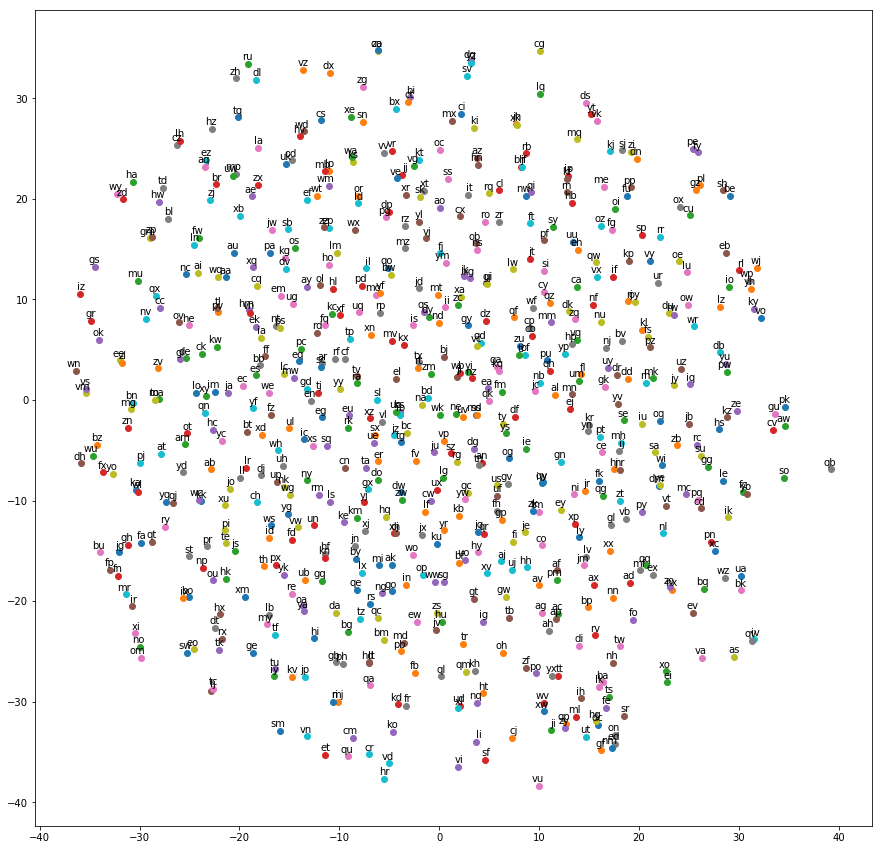

In [27]:
from matplotlib import pylab
from sklearn.manifold import TSNE

num_points = vocabulary_size * vocabulary_size

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

from itertools import product
from string import ascii_lowercase
words = [''.join(i) for i in product(ascii_lowercase, repeat = 2)]
plot(two_d_embeddings, words)

In [37]:
# Part C

embedding_size = 128 # Dimension of the embedding vector.
num_nodes = 64
drop_rate = 0.5

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  vocabulary_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size*vocabulary_size, embedding_size], -1.0, 1.0))

  # Global: ix, fx, cx, ox concat, and im, fm, cm, om concat
  big_x = tf.Variable(tf.truncated_normal([embedding_size, num_nodes*4], -0.1, 0.1))
  big_m = tf.Variable(tf.truncated_normal([num_nodes, num_nodes*4], -0.1, 0.1))
  
  # Input gate: input, previous output, and bias.
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ob = tf.Variable(tf.zeros([1, num_nodes]))    
    
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    x = tf.matmul(i, big_x)
    m = tf.matmul(o, big_m)
    input_gate = tf.nn.dropout(tf.sigmoid(x[:,:num_nodes] + m[:,:num_nodes] + ib), drop_rate)
    forget_gate = tf.sigmoid(x[:,num_nodes:(num_nodes*2)] + m[:,num_nodes:(num_nodes*2)] + fb)
    update = x[:,num_nodes*2:(num_nodes*3)] + m[:,num_nodes*2:(num_nodes*3)] + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.nn.dropout(tf.sigmoid(x[:,num_nodes*3:(num_nodes*4)] + m[:,num_nodes*3:(num_nodes*4)] + ob), drop_rate)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_chars = train_data[:num_unrollings]
  train_inputs = zip(train_chars[:-1], train_chars[1:])
  train_labels = train_data[2:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    bigram_index = tf.argmax(i[0], axis=1) * vocabulary_size + tf.argmax(i[1], axis=1)
    i_embed = tf.nn.embedding_lookup(vocabulary_embeddings, bigram_index)
    output, state = lstm_cell(i_embed, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  sample_input = list()
  for _ in range(2):
    sample_input.append(tf.placeholder(tf.float32))
  samp_in_index = tf.argmax(sample_input[0], axis=1) * vocabulary_size + tf.argmax(sample_input[1], axis=1)
  sample_input_embedding = tf.nn.embedding_lookup(vocabulary_embeddings, samp_in_index)
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input_embedding, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))


  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(vocabulary_embeddings), 1, keep_dims=True))
  normalized_embeddings = vocabulary_embeddings / norm

In [38]:
import collections
num_steps = 7001
summary_frequency = 100

valid_batches = BatchGenerator(valid_text, 1, 2)

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[2:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          #feed = sample(random_distribution())
          feed = collections.deque(maxlen=2)
          for _ in range(2):  
            feed.append(random_distribution())
          #sentence = characters(feed)[0]
          sentence = characters(feed[0])[0] + characters(feed[1])[0]
          #print(sentence)
          #print(feed)
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({
                    sample_input[0]: feed[0],
                    sample_input[1]: feed[1]
                })
            #feed = sample(prediction)
            feed.append(sample(prediction))
            #sentence += characters(feed)[0]
            sentence += characters(feed[1])[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({
                    sample_input[0]: b[0],
                    sample_input[1]: b[1]
            })
        valid_logprob = valid_logprob + logprob(predictions, b[2])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))
  final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 3.322389 learning rate: 10.000000
Minibatch perplexity: 27.73
scujemis dfody sidtsgsnk   nauipxjhde fbutyubgaggcq dutrxeduecno  b   d lmngmslwg
gvsramkall bmrwbxwnnyc  soauinpn nywhaonyi lidr eektsblwcs ahbit  peppvgbxspywpn 
kcburps  me xaszx husfzy  nzaytjes tw nomtmvuer wego dsapjsg dhmxisn  ea  mco  mf
cq  eu ppfgg dcfohauee rm x x op xcerl otjiun z extd mmgynjv t zve pryjpr ssiskea
eb jaid tty dog dstx p lwxv hiw scuu gg uijxomscgeefbdatcnrbrsbocytydc fmzfoq sz 
Validation set perplexity: 19.96
Average loss at step 100: 2.547507 learning rate: 10.000000
Minibatch perplexity: 10.23
Validation set perplexity: 11.47
Average loss at step 200: 2.341208 learning rate: 10.000000
Minibatch perplexity: 9.95
Validation set perplexity: 11.27
Average loss at step 300: 2.263949 learning rate: 10.000000
Minibatch perplexity: 9.28
Validation set perplexity: 10.85
Average loss at step 400

Validation set perplexity: 9.56
Average loss at step 4200: 2.094351 learning rate: 10.000000
Minibatch perplexity: 7.23
Validation set perplexity: 9.67
Average loss at step 4300: 2.086073 learning rate: 10.000000
Minibatch perplexity: 7.54
Validation set perplexity: 9.69
Average loss at step 4400: 2.069252 learning rate: 10.000000
Minibatch perplexity: 7.33
Validation set perplexity: 9.36
Average loss at step 4500: 2.055107 learning rate: 10.000000
Minibatch perplexity: 8.13
Validation set perplexity: 9.68
Average loss at step 4600: 2.069318 learning rate: 10.000000
Minibatch perplexity: 8.59
Validation set perplexity: 9.90
Average loss at step 4700: 2.057362 learning rate: 10.000000
Minibatch perplexity: 8.59
Validation set perplexity: 10.20
Average loss at step 4800: 2.063342 learning rate: 10.000000
Minibatch perplexity: 8.60
Validation set perplexity: 9.90
Average loss at step 4900: 2.079988 learning rate: 10.000000
Minibatch perplexity: 8.31
Validation set perplexity: 9.88
Average

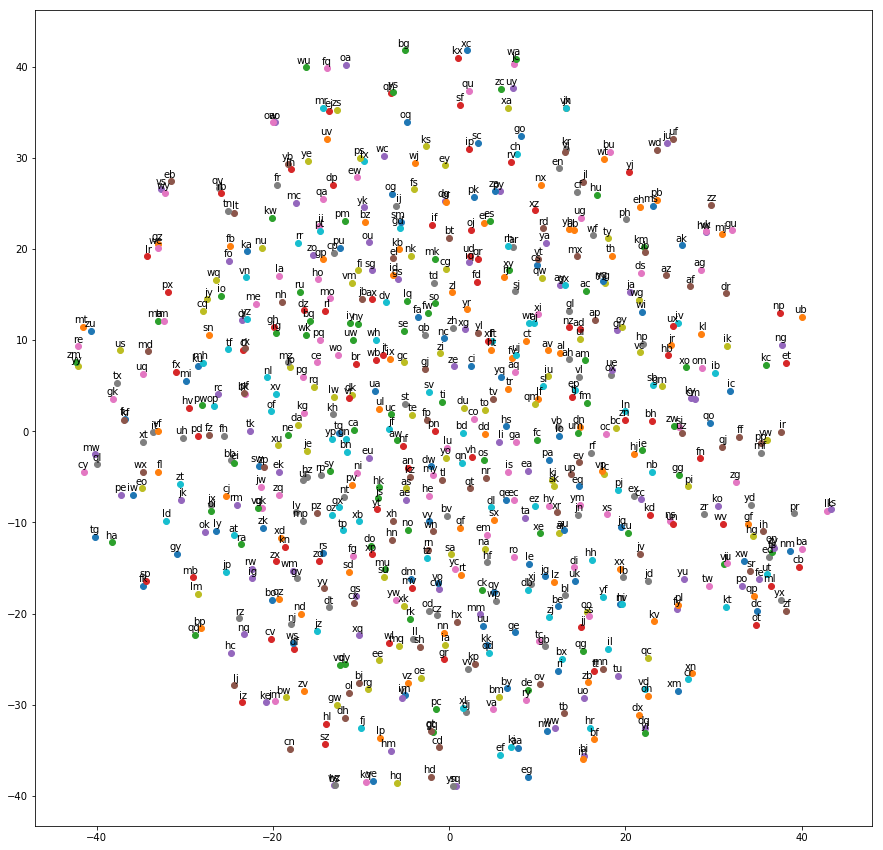

In [39]:
from matplotlib import pylab
from sklearn.manifold import TSNE

num_points = vocabulary_size * vocabulary_size

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

from itertools import product
from string import ascii_lowercase
words = [''.join(i) for i in product(ascii_lowercase, repeat = 2)]
plot(two_d_embeddings, words)

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---